# Trabajo Práctico 4: Redes

<p style="text-align: justify;">
En el marco de la materia optativa *Ciencia de Datos* estudiamos las técnicas de Teoría de Grafos a partir del análisis de la red de colaboraciones científicas mediante el paquete de Python [**networkx**](https://networkx.github.io/). En la [página web de la materia](http://www.dc.uba.ar/materias/cienciadatos) se encuentran disponibles los [datos](http://www.dc.uba.ar/materias/cienciadatos/tps/tp4/data.csv/view) utilizados, así como también las [referencias teóricas](http://www.dc.uba.ar/materias/cienciadatos/teoricas/teorica-Redes.pdf/view) y la [guía](http://www.dc.uba.ar/materias/cienciadatos/tps/tp4/Redes.pdf/view) para el desarrollo de los análisis correspondientes. <br>

<p style="text-align: justify;">
En el presente trabajo se analiza la red de colaboraciones científicas de publicaciones de física de altas energías del repositorio
ArXiv como una red compleja. 
</p> 

## Tabla de Contenidos 

<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->

- [0. Datos](#datos)
    - [0.1. Imports](#paquetes)  
    - [0.2. Carga y limpieza de datos](#limpieza)  
- [1. Creación del grafo](#grafo)
- [2. Distribución de grado](#grado)
- [3. Componentes conexas](#componentes)
- [4. Tamaños de vecindades](#vecindades)
- [5. Mundos pequeños](#mundospequeños)
- [6. Estrellas](#estrellas)
<!-- /MarkdownTOC -->

<a name="datos"></a>
## 0. Datos

<p style="text-align: justify;">
El archivo `data.csv` contiene una lista de publicaciones de física de altas energías del repositorio ArXiv. En esta práctica vamos a estudiar el grafo de colaboraciones entre autores, en el que los nodos representan autores y las aristas coautorías. Vamos a usar un grafo simple no dirigido, en el que basta una coautoría para que haya una conexión entre dos autores.
</p> 

<a name="paquetes"></a>
## 0.1. Imports

<p style="text-align: justify;">
Cargamos los paquetes de Python a utilizar.
</p> 

In [3]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [4]:
import pandas as pd
import pickle
import itertools
import networkx as nx
import collections 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os.path

/home/march/anaconda2/envs/py3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<a name="limpieza"></a>
## 0.2. Carga y limpieza de datos

#### Levantamos los datos del csv

Para cada publicación se cuenta con el año, un código relacionado con la revista y el tema, la revista, los autores y el título.

In [3]:
with open('data.csv', 'r') as f:
    rows = [[c.strip() for c in l.split(',', 4)]
             for l in f]


In [4]:
papers = pd.DataFrame(rows, columns=['year', 'id', 'journal', 'authors', 'title'])

In [8]:
papers.head()

,year,id,journal,authors,title
0,1992,B368,Nucl.Phys.,Horne & Horowitz,Exact Black String Solutions in Three Dimensions
1,1992,B278,Phys. Lett.,Mikovic,Hamiltonian construction of W-gravity actions
2,1991,A6,Mod. Phys. Lett.,Huitu & Nemeschansky,Supersymmetric Gelfand-Dickey Algebra
3,1992,B373,Nucl.Phys.,Witten,Ground Ring Of Two Dimensional String Theory
4,1991,A6,Mod.Phys.Lett.,Intriligator,Fusion Residues


####  Limpiamos los datos

En una primera inspección de la tabla de datos se observa que para ciertos casos la información provista ó bien no está ordenada correctamente ó está incompleta ó hay demás. Se filtraron estos casos y se continúa con la generación del grafo.

In [5]:
banned_indexs = [2114, 6166, 6167, 6396, 6397, 6398, 7189]

In [6]:
papers.loc[banned_indexs]

,year,id,journal,authors,title
2114,1994,B328,Phys.Lett.,Nikolaev & Zakharov & IKP & Juelich & Juelich ...,The spectrum and solutions of the generalized ...
6166,1995,B349,lectures in Formation and Interactions of Topo...,,None
6167,NATO ASI B349,ed A.-C. Davis,R.,Carter,Dynamics of Cosmic Strings and other Brane models
6396,1997,P21,GROUP21,Physical Applications and Mathematical Aspects of,None
6397,Geometry,Groups and Algebras,vol. 2,eds. H.-D. Doebner e.a. World Sci.,
6398,Singapore,1997) p.,Kanatchikov,Novel algebraic structures from the polysymple...,None
7189,1998,E57,Phys.Rev.,Caiani & Casetti & Clementi & Pettini & Pettin...,Geometry of dynamics and phase transitions in ...


In [7]:
papers = papers.drop(papers.index[banned_indexs])

In [8]:
papers.to_csv('data.limpia.csv')

<a name="grafo"></a>
## 1. Creación del grafo

#### Extraemos todos los autores

In [5]:
papers = pd.read_csv('data.limpia.csv')

In [6]:
def authors_from_text(text):
    "Devuelve la lista de autores de texto como 'A & B & C'"
    s = text.split('&')
    return [x.strip() for x in s]

In [7]:
authors = [author
           for text in papers['authors']
           for author in authors_from_text(text)]

#### Extraemos las coautorías

In [8]:
co_authors = [list(itertools.combinations(set(authors_from_text(authors)), 2))
              for authors in papers['authors']]
co_authors = [x for x in co_authors if len(x) != 0]
co_authors = [co_autoria 
              for co_autorias in co_authors
              for co_autoria in co_autorias]

#### Creamos el grafo

In [9]:
grafo_citas = nx.Graph()

In [10]:
grafo_citas.add_nodes_from(authors)

In [11]:
grafo_citas.add_edges_from(co_authors)

La cantidad de nodos y eje que forman el grafo son:

In [12]:
print('# de nodos: {}'.format(len(grafo_citas.nodes())))
print('# de ejes: {}'.format(len(grafo_citas.edges())))

# de nodos: 4003
# de ejes: 7782


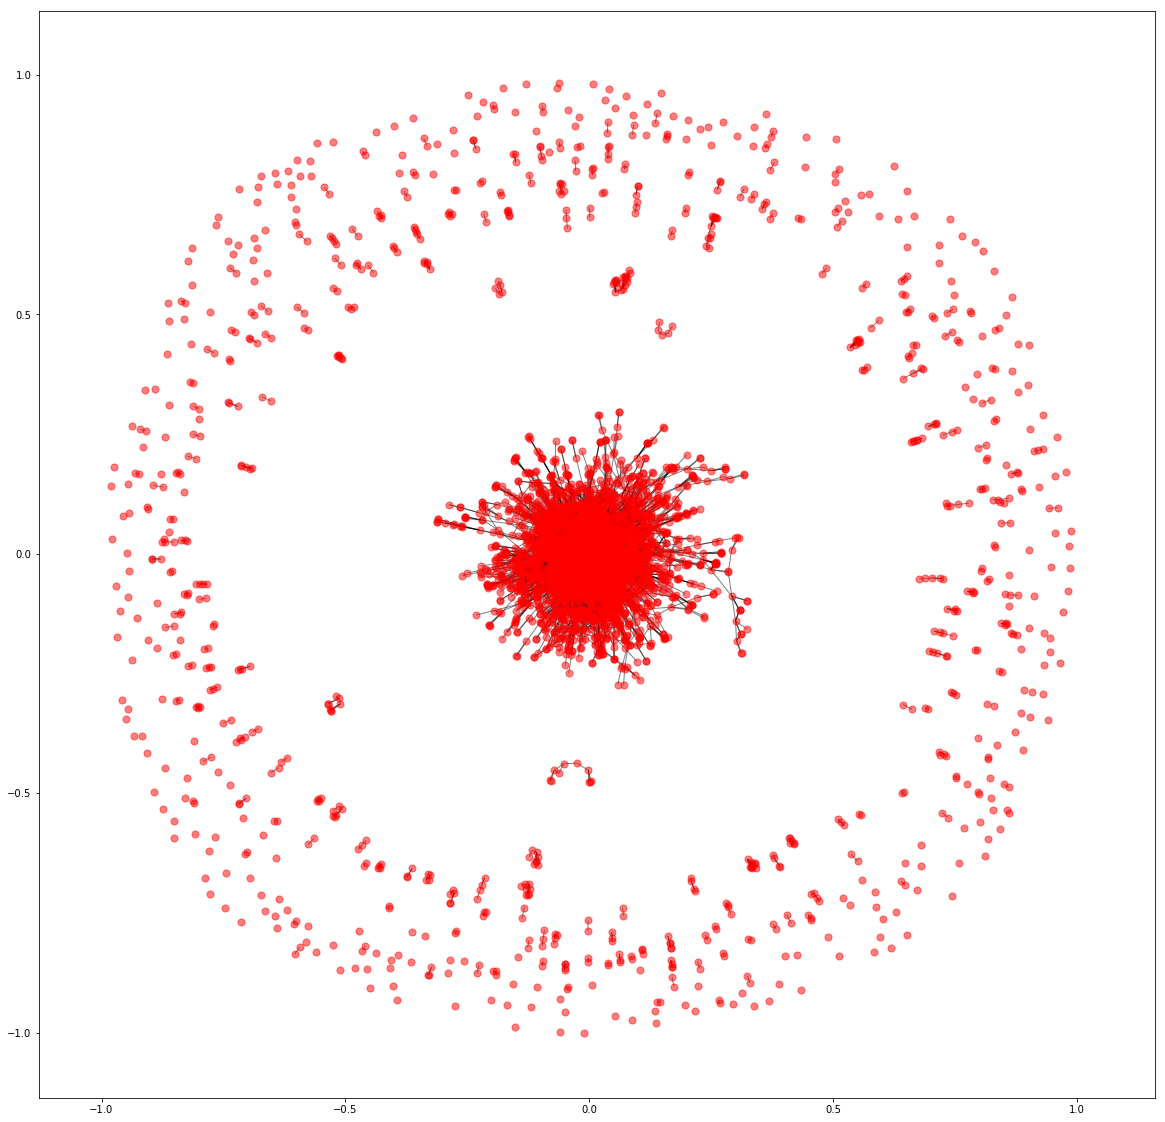

In [13]:
pos = nx.drawing.spring_layout(grafo_citas)
plt.figure(figsize(20, 20))
nx.draw_networkx(grafo_citas, pos, with_labels=False, node_size=50, alpha=0.5)

En el grafo se observa una gran cantidad de nodos centrales y conectados entre sí, formando una suerte de subconjunto. A su alrededor se disponen aquellos nodos sin conexiones o con pocas (~5).

A continuación se emplean herramientas específicas para caracterizar el grafo y el comportamiento de sus partes.

<a name="grado"></a>
##  2. Distribución de Grado

Para comenzar con la descripción del grafo se estudiará la distribución de grado de cada nodo.

In [14]:
deg = [len(nbrs) for n,nbrs in grafo_citas.adj.items()]
count = collections.Counter(sorted(deg))


Se grafica la distribución de grados de nodos en diferentes escalas para decidir cuál es la más apropiada en este caso.

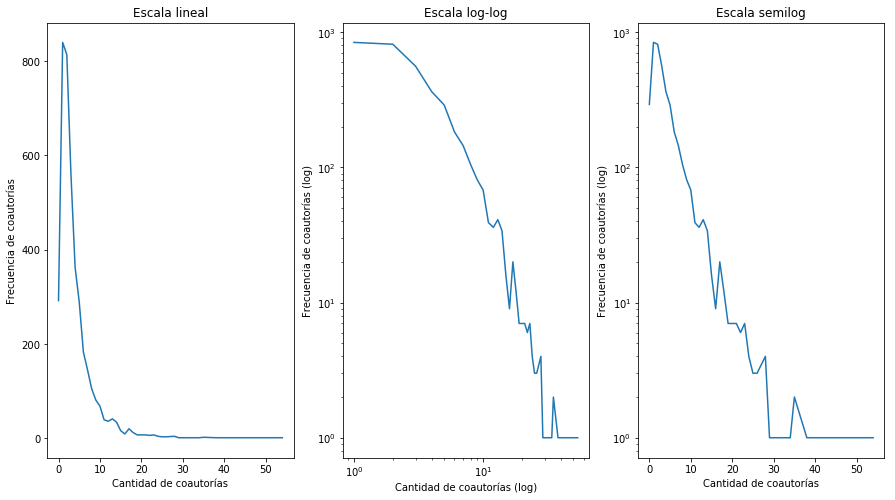

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(15, 8))
xs = list(count.keys())
ys = list(count.values())

sca(axs[0])
plot(list(count.keys()), list(count.values()))
xlabel('Cantidad de coautorías')
ylabel('Frecuencia de coautorías')
title('Escala lineal')

sca(axs[1])
loglog(list(count.keys()), list(count.values()))
xlabel('Cantidad de coautorías (log)')
ylabel('Frecuencia de coautorías (log)')
title('Escala log-log')

sca(axs[2])
semilogy(list(count.keys()), list(count.values()))
xlabel('Cantidad de coautorías')
ylabel('Frecuencia de coautorías (log)')
title('Escala semilog')
plt.show()

Eliminamos las colas (vemos hasta 30 co-autorías y eliminamos los autores sin co-autorías)

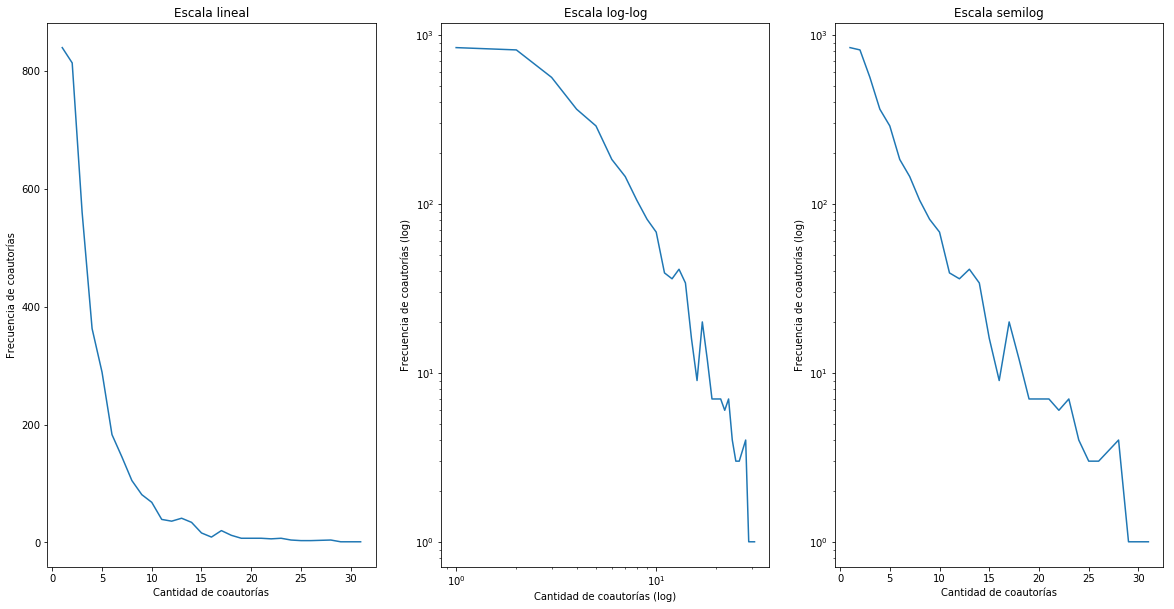

In [13]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
sca(axs[0])
plot(xs[1:30], ys[1:30])
xlabel('Cantidad de coautorías')
ylabel('Frecuencia de coautorías')
title('Escala lineal')

sca(axs[1])
loglog(xs[1:30], ys[1:30])
xlabel('Cantidad de coautorías (log)')
ylabel('Frecuencia de coautorías (log)')
title('Escala log-log')

sca(axs[2])
semilogy(xs[1:30], ys[1:30])
xlabel('Cantidad de coautorías')
ylabel('Frecuencia de coautorías (log)')
title('Escala semilog')
plt.show()

Vale recordar que si es una escala logarítmica en ambos ejes la que mejor representa los datos estamos en presencia de una distribución del tipo Ley de potencias mientras que si la escala logarítmica es representativa sólo en el eje $y$ la distribución es exponencial. Teniendo en cuenta que con una inspección cualitativa no se puede elegir con seguridad si estamos en presencia de un caso o el otro, realizamos un ajuste lineal y se reporta el valor de $R^2$ para ambos casos.

In [22]:
exp_rs = sm.OLS(np.log(ys[1:]), xs[1:]).fit()
print('Exp R^2: {:.4f}'.format(exp_rs.rsquared))
power_rs = sm.OLS(np.log(ys[1:]), np.log(xs[1:])).fit()
print('Power-law R^2: {:.4f}'.format(power_rs.rsquared))

Exp R^2: 0.1352
Power-law R^2: 0.3323


En ninguno de los dos ajustes se obtiene un resultado contundente en cuanto a la linealidad del gráfico anailzado. Sin embargo, el valor de $R^2$ obtenido para el caso de la ley de potencias es mayor, por lo que en caso de ser necesario, se tomará este resultado.

<a name="componentes"></a>
##  3. Componentes conexas

In [85]:
#El tamanio de las componentes conexas tiene que ver con la probabilidad
#de los ejes de conectar nodos. Puede ser que esto sirva para algo, no termino de entenderlo.
#quien es mi p para comparar contra estos dos p??

# @march: Ni idea que onda esto. ¿Es por lo de percolation de las diapos?

n= len(grafo_citas.nodes())
# p valor al cual se espera que haya componente gigante con tamanio ~ log(n)
p_giant=1.0/(n-1)
# valor en el que se espera que los nodos esten todos conectados (no haya componente gigante)
p_conn=math.log(n)/float(n) 
print('p_giant: {}'.format(p_giant))
print('p_conn: {}'.format(p_conn))

p_giant: 0.0002498750624687656
p_conn: 0.0020721457304503058


In [61]:
nx.is_connected(grafo_citas)

False

In [70]:
nx.number_connected_components(grafo_citas)
print('Cantidad de componentes conexas: {}'.format(nx.number_connected_components(grafo_citas)))

Cantidad de componentes conexas: 530


In [27]:
components = list(nx.connected_components(grafo_citas))
subgrafo_citas = list(nx.connected_component_subgraphs(grafo_citas))

#### Componente gigante

Se define y grafica la componente gigante del grafo

In [28]:
# sorted
components_sorted = sorted(subgrafo_citas, key=len, reverse=True)
giant_component = components_sorted[0]
print('Cantidad de nodos: {}'.format(len(giant_component.nodes())))
print('Cantidad de ejes: {}'.format(len(giant_component.edges())))

Cantidad de nodos: 3016
Cantidad de ejes: 7147


In [198]:
components_id = list(enumerate(components))  # :: [(id, componente)]
node_to_id = dict([(nodo, id_componente)  # :: nodo -> id_componente
                   for id_componente, nodos_componentes in components_id
                   for nodo in nodos_componentes])
nodes_ids = [node_to_id[n] for n in grafo_citas.nodes()]  # [id_componente] para cada nodo

In [199]:
nx.is_connected(giant_component)

True

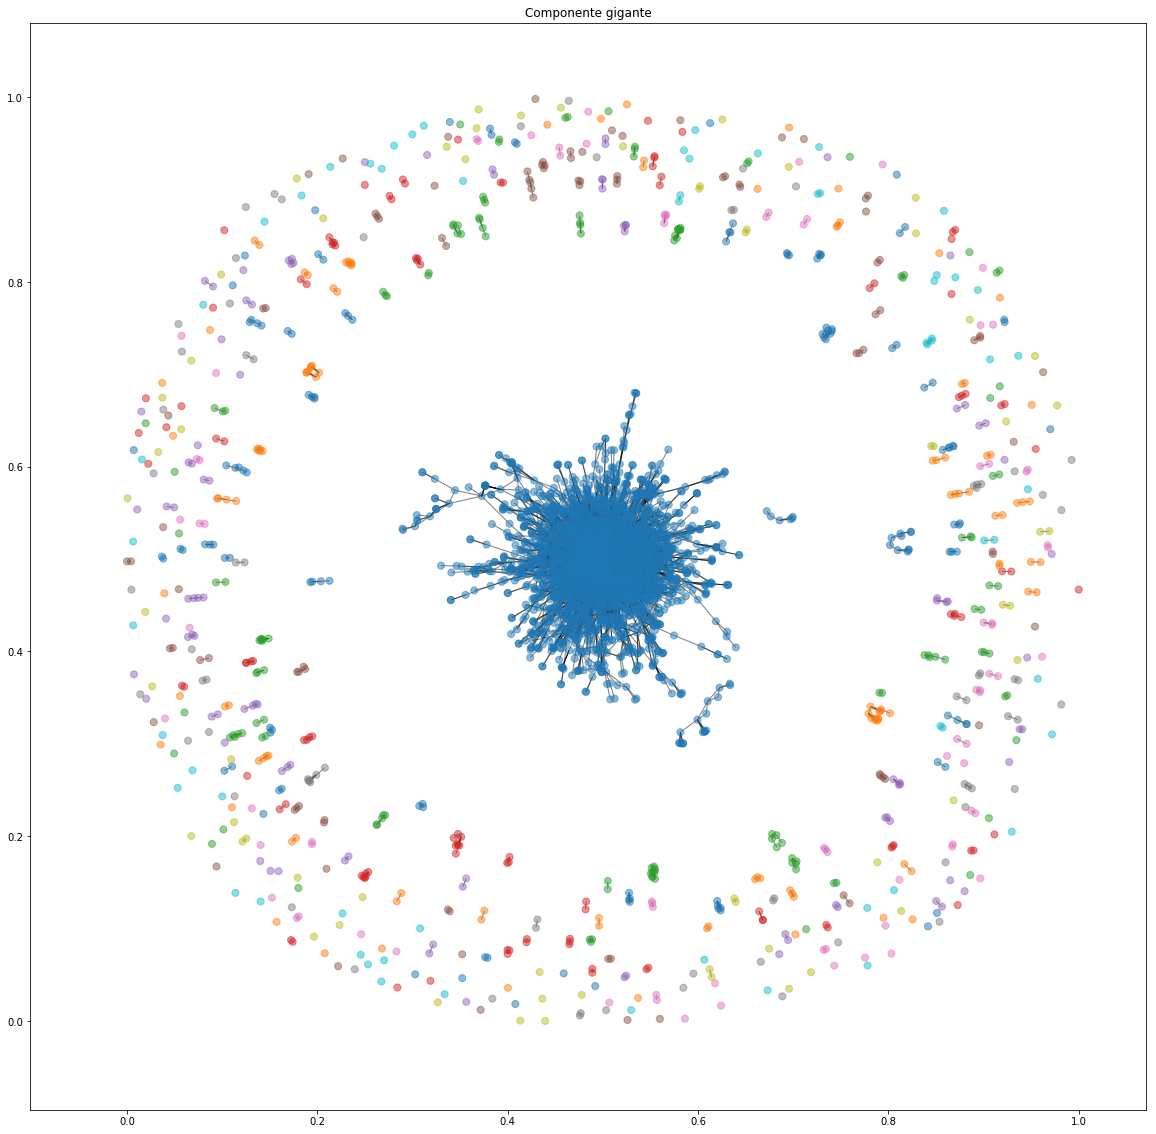

In [200]:
plt.figure(figsize(20, 20))
nx.draw_networkx(grafo_citas, pos=pos node_size=50, alpha=0.5, 
                 node_color=nodes_ids, with_labels=False, cmap=cm.tab10)
title('Componente gigante')

En el gráfico se observa la componente gigante del grafo en color rojo compuesta por 3016 nodos de los 4003 totales y 7147 ejes de 7807. Tal como se esperaba, aquí es donde se encuentra la mayor densidad de nodos y enlaces describiendo una fuerte interacción en las publicaciones de los autores correspondientes. Esto coincide con lo observado y reportado en la primer representación del grafo como el "subconjunto central" de nodos.

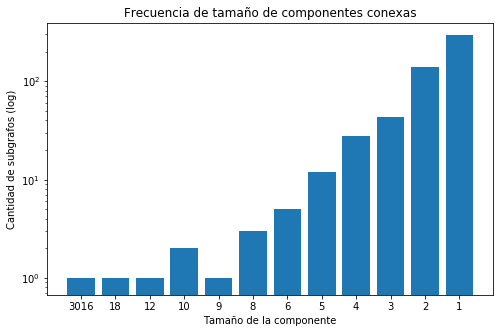

In [98]:
components_sizes = [len(c) for c in components]
c = collections.Counter(components_sizes)
xs = sorted(c.keys(), reverse=True)
ys = [c[x] for x in xs]
figure(figsize=(8, 5))
bar(range(len(xs)), ys, tick_label=xs, log=True)
title('Frecuencia de tamaño de componentes conexas')
xlabel('Tamaño de la componente')
_ = ylabel('Cantidad de subgrafos (log)')

<a name="vecindades"></a>
##  4. Tamaños de vecindades

In [33]:
def roberto_carlos(G, nodo_inicial):
    """
    Calcula el esparcimiento en el grafo a partir del nodo inicial.
    
    Args:
        G: Grafo inicial
        nodo_inicial: nodo del grafo a partir del cual se calcula esparcimiento
        
    Return:
        {
            'visitados': nodos visitados en cada paso,
            'agregados': nodos agregados en cada paso
        }
    """
    por_ver = set([nodo_inicial])
    vistos = set()
    visitados = []
    agregados = []
    while len(por_ver) > 0:
        proximos = set([vecino
                        for n in por_ver
                        for vecino in G[n]])
        por_ver = proximos - vistos
        agregados.append(len(por_ver))
        vistos = vistos | proximos
        visitados.append(len(vistos))
        
    return {
        'visitados': visitados,
        'agregados': agregados
    }

In [34]:
elegidos_gigante = random.choice(giant_component.nodes(), size=30, replace=False)

In [39]:
df = pd.DataFrame.from_records(
    [roberto_carlos(giant_component, n) for n in elegidos_gigante]
)

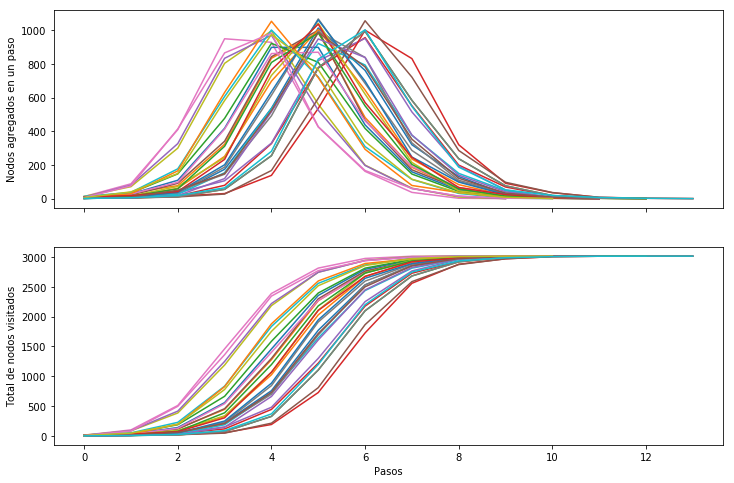

In [49]:
fig, axs = subplots(2, 1, figsize=(12, 8), sharex=True)
sca(axs[0])
for agregados in df['agregados']:
    plot(range(len(agregados)), agregados)
    
ylabel('Nodos agregados en un paso')

sca(axs[1])
for visitados in df['visitados']:
    plot(range(len(visitados)), visitados)
    
ylabel('Total de nodos visitados')
    
xlabel('Pasos')

<a name="mundospequeños"></a>
##  5. Mundos pequeños

Calculamos el coeficiente de clustering promedio de la componente gigante del grafo.

In [97]:
cc = nx.clustering(giant_component)
type(cc)

dict

In [98]:
cc_list = list(cc.values())
mean(cc_list)

0.47861863375943958

In [99]:
average_cc = nx.average_clustering(giant_component)
average_cc

0.4786186337594398

Calculamos el camino mínimo medio.

In [100]:
nx.average_shortest_path_length(giant_component)

6.0536554627393535

Generamos un grafo aleatorio con la misma distribución de grado y computamos las mismas medidas para este grafo.

    BUSCAR SI NO HAY UNA FUNCION DENTRO DE NETWORKX QUE HAGO RANDOM CON DEGREE PRESERVING. COMO POR EJEMPLO LA DE EXPECTED DEGREE SEQUENCE O ALGUNA DE ESAS.

https://gist.github.com/gotgenes/2770023

    NOTA: LE TUVE QUE HACER UNA ADAPTACION CUANDO PASE DE LA VERSION 1.1 A LA 2.0 DEL NETWORKX PORQUE EL ATRIBUTO EDGED DEL GRAFO AHORA ES DIFERENTE Y ENTONCES LO TUVE QUE CONVERTIR EN LISTA.

In [115]:
import random
def randomize_by_edge_swaps(self, num_iterations):

    newgraph = self.copy()
    #edge_list = newgraph.edges() #v1.1
    edge_list = list(newgraph.edges()) #v2.0
    num_edges = len(edge_list)
    total_iterations = num_edges * num_iterations

    for i in range(total_iterations):
        rand_index1 = int(round(random.random() * (num_edges - 1)))
        rand_index2 = int(round(random.random() * (num_edges - 1)))
        original_edge1 = edge_list[rand_index1]
        original_edge2 = edge_list[rand_index2]
        head1, tail1 = original_edge1
        head2, tail2 = original_edge2

        # Flip a coin to see if we should swap head1 and tail1 for
        # the connections
        if random.random() >= 0.5:
            head1, tail1 = tail1, head1

        # The plan now is to pair head1 with tail2, and head2 with
        # tail1
        #
        # To avoid self-loops in the graph, we have to check that,
        # by pairing head1 with tail2 (respectively, head2 with
        # tail1) that head1 and tail2 are not actually the same
        # node. For example, suppose we have the edges (a, b) and
        # (b, c) to swap.
        #
        #   b
        #  / \
        # a   c
        #
        # We would have new edges (a, c) and (b, b) if we didn't do
        # this check.

        if head1 == tail2 or head2 == tail1:
            continue

        # Trying to avoid multiple edges between same pair of nodes;
        # for example, suppose we had the following
        #
        # a   c
        # |*  |           | original edge pair being looked at
        # | * |
        # |  *|           * existing edge, not in the pair
        # b   d
        #
        # Then we might accidentally create yet another (a, d) edge.
        # Note that this also solves the case of the following,
        # missed by the first check, for edges (a, b) and (a, c)
        #
        #   a
        #  / \
        # b   c
        #
        # These edges already exist.

        if newgraph.has_edge(head1, tail2) or newgraph.has_edge(
                head2, tail1):
            continue

        # Suceeded checks, perform the swap
        original_edge1_data = newgraph[head1][tail1]
        original_edge2_data = newgraph[head2][tail2]

        newgraph.remove_edges_from((original_edge1, original_edge2))

        new_edge1 = (head1, tail2, original_edge1_data)
        new_edge2 = (head2, tail1, original_edge2_data)
        newgraph.add_edges_from((new_edge1, new_edge2))

        # Now update the entries at the indices randomly selected
        edge_list[rand_index1] = (head1, tail2)
        edge_list[rand_index2] = (head2, tail1)

    assert len(newgraph.edges()) == num_edges
    return newgraph


o tambien
https://github.com/benmaier/Degree-preserving-Randomization

In [116]:
num_iterations = 1000
giant_component_random = randomize_by_edge_swaps(giant_component, num_iterations)

In [117]:
nx.average_clustering(giant_component_random)

0.004011173999640548

In [118]:
nx.average_shortest_path_length(giant_component_random)

NetworkXError: Graph is not connected.

    ACA HAY UN TEMA A TENER EN CUENTA, PORQUE EL AVERAGE PATH LENGTH LO CALCULA SOLO SI EL GRAFO ESTA CONECTADO. SI HACEMOS RANDOM DEGREE PRESERVING DE LA COMPONENTE GIGANTE, NO QUEDA CONECTADO Y ENTONCES NO SE PUEDE CALCULAR. ENTONCES UNA OPCION ES RANDOMIZAR TODO EL GRAFO Y DESPUES CALCULAR LA COMPONENTE GIGANTE DE LA RED RANDOMIZADA Y CALCULAR TODO.

In [119]:
num_iterations = 1000
grafo_citas_random = randomize_by_edge_swaps(grafo_citas, num_iterations)

In [120]:
nx.is_connected(grafo_citas_random)

False

In [121]:
nx.number_connected_components(grafo_citas_random)

327

In [122]:
components_random = nx.connected_components(grafo_citas_random)

In [123]:
nx.connected_component_subgraphs(grafo_citas_random)

<generator object connected_component_subgraphs at 0x0000027416607A40>

In [124]:
# identify largest connected component
components_sorted_random = sorted(nx.connected_component_subgraphs(grafo_citas_random), key=len, reverse=True)
giant_component_random = components_sorted_random[0]

In [125]:
print('Cantidad de nodos: {}'.format(len(giant_component_random.nodes())))
print('Cantidad de ejes: {}'.format(len(giant_component_random.edges())))

Cantidad de nodos: 3635
Cantidad de ejes: 7765


In [126]:
nx.average_clustering(giant_component_random)

0.0028840592431696945

In [127]:
nx.average_shortest_path_length(giant_component_random)

5.057628435099045

    Y SE PUEDE HACER UN LOOP CON VARIAS RANDOMIZACIONES PARA OBTENER EL INTERVALO DE VALORES QUE DA EL RANDOM Y VER SI PRESENTA DIFERENCIAS SIGNIFICATIVAS CON LA RED REAL.

<a name="estrellas"></a>
##  6. Estrellas

In [143]:
centrality_metrics = collections.OrderedDict({
    'degree': nx.degree_centrality,
    'eigen': nx.eigenvector_centrality,
    'closeness': nx.closeness_centrality,
    'betweeness': nx.betweenness_centrality
})

In [52]:
CENTRALITY_PKL = 'centrality_scores.pkl'
if not os.path.isfile(CENTRALITY_PKL):
    centrality_scores = collections.OrderedDict(
        [(k, metric(grafo_citas)) for k, metric in centrality_metrics.items()]
    )
    with open(CENTRALITY_PKL, 'wb') as f:
        pickle.dump(centrality_scores, f)
else:
    with open(CENTRALITY_PKL, 'rb') as f:
        centrality_scores = pickle.load(f)

In [153]:
percentile = .2

In [166]:
percentile_most_central = collections.OrderedDict(
    [(k, dict(sorted(scores.items(), key=lambda x: x[1], reverse=True)[:int(len(scores) * percentile)]))
     for k, scores in centrality_scores.items()]
)

In [169]:
sizes = [sum([1 for centrals in percentile_most_central.values() if n in centrals])
         for n in grafo_citas.nodes()]
filtered_sizes = [s for s in sizes if s > 0]

1 366
2 356
3 198
4 382


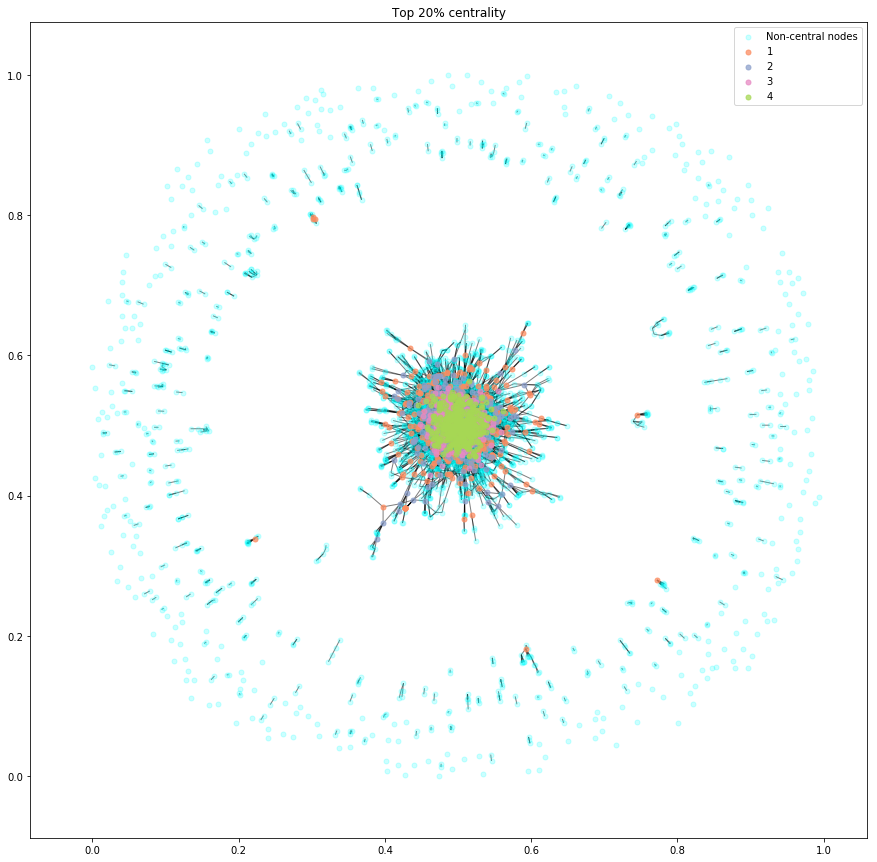

In [233]:
figure(figsize=(15, 15))
# pos = nx.layout.spring_layout(grafo_citas)
nx.draw_networkx_edges(grafo_citas, pos, alpha=0.5)

nx.draw_networkx_nodes(grafo_citas, pos, with_labels=False, node_size=25, 
                       nodelist=[n for n, s in zip(grafo_citas.nodes(), sizes) if s == 0],
                       node_color='cyan', alpha=0.2, label='Non-central nodes')

for size in range(1, 5):
    nl = [n for n, s in zip(grafo_citas.nodes(), sizes) if s == size]
    print(size, len(nl))
    nx.draw_networkx_nodes(grafo_citas, pos, with_labels=False, node_size=25, nodelist=nl, 
                           node_color=cm.Set2(size), alpha=0.75, label=str(size))
    
legend()
title('Top 20% centrality')

In [234]:
def plot_selectivity(centrality_scores, label=None):
    scores = np.array(centrality_scores)
    stops = np.linspace(max(centrality_scores), min(centrality_scores), 20)
    xs = np.linspace(0, 1, 20)
    ys = np.array([sum(scores > s) for s in stops]) / len(centrality_scores)
    plot(xs, ys, label=label)

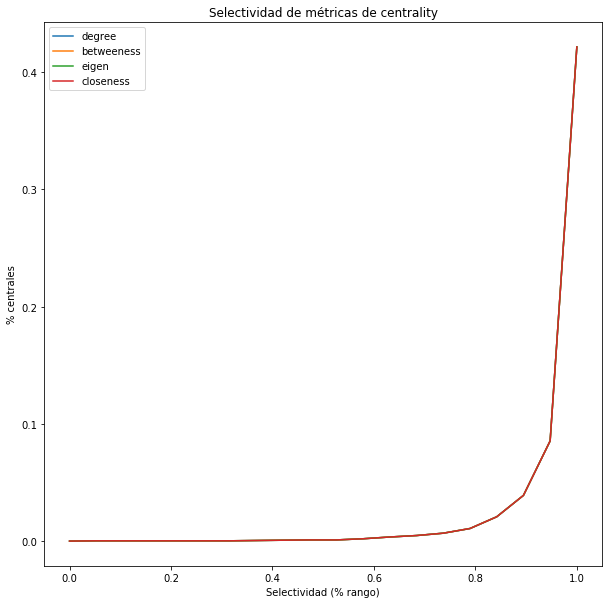

In [236]:
figure(figsize=(10, 10))
for name, scores in centrality_scores.items():
    plot_selectivity(list(centrality.values()), name)
xlabel('Selectividad (% rango)')
ylabel('% centrales')
title('Selectividad de métricas de centrality')
legend()

In [81]:
def eliminamos_centros(G, centrality_scores, pasos):
    """
    Elimina nodos centrales sucesivamente y calcula el tamaño de la componente gigante.
    
    Args:
        G: grafo
        centrality_scores: diccionario nodo -> score centralidad
        pasos: cantidad de pasos a realizar
        
    Return:
        lista de tamaños de componente gigante
    """
    g = G.copy()
    t_gigante = []
    nodos_centrales = [x[0] for x in sorted(centrality_scores.items(), key=lambda x: x[1])]
    while pasos > 0:
        c_c_gen = [list(x) for x in nx.connected_components(g)]
        c_gigante = max(c_c_gen, key=len)
        t_gigante.append(len(c_gigante))
        n_central = nodos_centrales.pop()
        # n_central = nodos_centrales[-1]
        # nodos_centrales = nodos_centrales[:-1]
        g.remove_node(n_central)
        pasos -= 1
        
    return t_gigante

In [87]:
pasos = 1000

In [93]:
metrics_ts = dict([(name, eliminamos_centros(grafo_citas, scores, pasos))
                   for name, scores in centrality_scores.items()])

In [85]:
random_scores = [dict(zip(grafo_citas.nodes(), random.uniform(size=len(grafo_citas))))
                 for _ in range(5)]

In [88]:
random_ts = np.array([eliminamos_centros(grafo_citas, rs, pasos) for rs in random_scores])

In [91]:
random_ts_mean = np.mean(random_ts, axis=0)

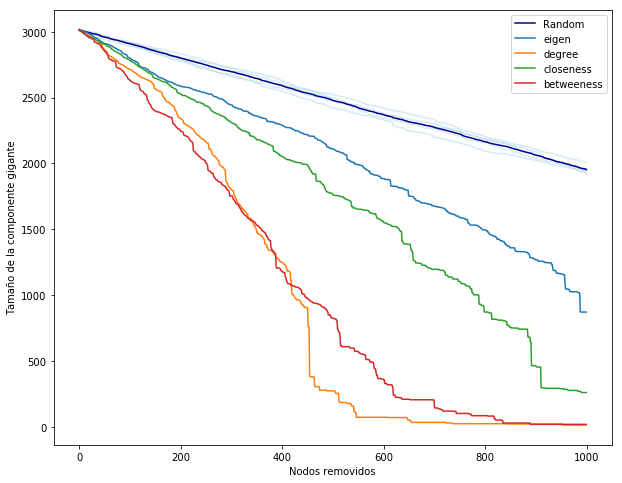

In [94]:
figure(figsize=(10, 8))

for ts in random_ts:
    plot(range(len(ts)), ts, color='lightblue', alpha=0.5)
    
plot(range(len(random_ts_mean)), random_ts_mean, color='darkblue', label='Random')

for name, ts in metrics_ts.items():
    plot(range(len(ts)), ts, label=name)
xlabel('Nodos removidos')
ylabel('Tamaño de la componente gigante')
legend()